**Reminder: always use `Kernel > Restart & Run All` and check the results before submitting.**

# CV Lab Exercise 2: Warping & Estimation

In [1]:
# The imports for the code in this lab

import numpy as np
import matplotlib.pyplot as plt
import wget
from skimage.transform import warp

Hidden in this cell are some $\LaTeX$ macros
$\newcommand{\v}[1]{\mathbf #1}$
$\newcommand{\hv}[1]{\widetilde{\mathbf #1}}$
$\newcommand{\setR}{\mathbb R}$
$\newcommand{\T}{^\top}$
$\newcommand{\inv}{^{-1}}$

## Interpolation

In a previous LabExercise you have written the ``pixel_value`` function. We will need that function again in this lab, and we are extending it with multiple ways of handling the border of the image. (2pt)

The named (or keyword) argument ``interpolation`` can have value ``'nearest'`` or ``'bilinear'`` indicating the type of interpolation. The argument ``mode`` indicates the way the border problem is taken care of. Valid values are ``'nearest'`` and ``'constant'``. If ``mode='constant'`` then the named argument ``cval`` provides the constant value to be used. You may additionally implement ``mode=wrap`` if you are interested, but this is optional.

In [2]:
def pixel_value(F, y, x, interpolation_method='nearest', 
                border_method='constant', cval=0):
    """
    This function returns the interpolated function value for the function
    given by numpy array F. The valid interpolation methods are 'nearest' and
    'bilinear'. The modes for dealing with points outside the border of F are 
    'nearest' and 'constant' (and possibly 'wrap', depending on implementation). 
    The optional parameter cval gives the value to be returned outside the borders
    of F, in case `border_method == 'constant'`.
    """
    width = F.shape[1] - 1
    height = F.shape[0] - 1
    if not in_image(F.shape, y, x):
        if border_method == 'constant':
            return cval
        elif border_method == 'nearest':
            #Get the closest x and y
            if x < 0:
                x = 0
            elif x > width:
                x = width

            if y < 0:
                y = 0
            elif y > height:
                y = height
    
    if interpolation_method == 'nearest':
        i = int(x + (1/2))
        j = int(y + (1/2))
        if in_image(F.shape, j, i):
            return F[j][i]
        nearest = pixel_value(F, j, i, interpolation_method, border_method)
        return nearest
    elif interpolation_method == 'bilinear':
        i, a = int(x), x % 1
        j, b = int(y), y % 1
        if a == 0 and b == 0:
            return F[j][i]
        else:
            c1 = (1 - a) * (1 - b) * pixel_value(F, j, i, interpolation_method, border_method)
            c2 = (1 - a) * b * pixel_value(F, j + 1, i, interpolation_method, border_method)
            c3 = a * (1 - b) * pixel_value(F, j, i + 1, interpolation_method, border_method)
            c4 = a * b * pixel_value(F, j + 1, i + 1, interpolation_method, border_method)
        return c1 + c2 + c3 + c4
    
def in_image(image_shape, y, x):
    width = image_shape[1] - 1
    height = image_shape[0] - 1
    if x <= width and x >= 0 and y <= height and y >= 0:
        return True
    else:
        return False

We will test this function on a simple very small version of a standard image ``trui.png``. The code below tries to read the image from the directory where this notebook is stored. If the file can't be read an exception is thrown and caught. Then the file is downloaded from the computer vision web pages and again the file is read.

For starting Python programmers this way of programming might be counter intuitive. Perhaps you would like first to check if the file exists in the local directory and if not download it. This is the classical *Look before you leap (LBYL)* paradigm in programming. In Python one often uses the *Easier to Ask for Forgiveness than Permission (EAFP)* approach. Search the web for all the pros and cons of both approaches.

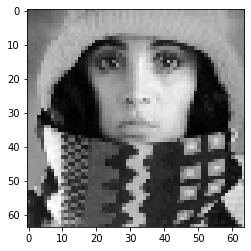

In [3]:
try:
    F = plt.imread('trui.png')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/trui.png")
    F = plt.imread('trui.png')
Fsmall = F[::4,::4]
plt.imshow(Fsmall)
plt.gray()

We then test your ``pixel_value`` function. We make a new image ``G`` by sampling the image ``F`` in 128x128 points. At position (x,y) in image G we sample image G at position (x-32, y-32). If all is well you should end up with an image G that shows image F in its center and the border around it should be determined by the border mode that is selected.

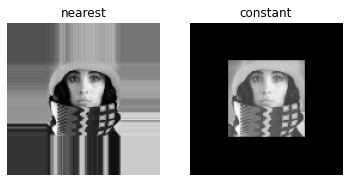

In [4]:
# Note only border modes 'constant' and 'nearest' are mandatory. 
# Switch the following two lines only if you have implemented all three modes, which is optional.

# modes_implemented = ['nearest', 'constant', 'wrap'] 
modes_implemented = ['nearest', 'constant']

G = {}
for mode in modes_implemented:
    G[mode] = np.zeros((128,128))

for y in range(128):
    for x in range(128):
        for m in modes_implemented:
            G[m][y, x] = pixel_value(Fsmall, y-32, x-32, 
                                     interpolation_method='nearest', border_method=m, cval=0)
            
n = len(modes_implemented)
for i, mode in enumerate(modes_implemented):
    plt.subplot(1,n,i+1)
    plt.imshow(G[mode])
    plt.title(mode)
    plt.axis('off')


If the ``pixel_value`` function is working with at least the 'nearest' and 'constant' border mode, we will continue with some exercises and questions regarding homogeneous coordinates. These are a mathematical tool to efficiently describe describe commonly used geometrical transformations.

## Homogeneous Coordinates and Rotations

Before you continue reading this notebook, make sure you have read the section on homogeneous coordinates in the lecture notes in the 'Mathematical Tools' chapter.

A 2D point $\v x = (a\;\; b)\T$ is represented with a homogeneous vector $\hv x = (s\,a\;\;s\,b\;\;s)\T$ where $s$ can be any real number not equal zero. In this LabExercise we will often find the need to take a vector $\v x$ and make a homogeneous representation $\hv x$ for it. In Numpy a vector $\v x\in\setR^2$ is represented with a (2,) shaped array and the homogeneous vector $\hv x$ is represented with a (3,) shaped array. A 'normal' vector $\v x$ is often called a Euclidean vector, in contrast with $\hv x$ being a homogeneous vector.

Much later on in the course we will consider Euclidean vectors in 3 dimsional space as well. A vector $\v x = (a\;\;b\;\;c)\T\in\setR^3$ in homogeneous representation is $\hv x = (s\,a\;\;s\,b\;\;s\,c\;\;s)\T$.

Write the functions ``e2h`` that takes a (matrix of) Euclidean vector(s) as input (either a 2 or 3 dimensional vector) and returns the corresponding homogeneous vector(s). Als write the function ``h2e`` that does the opposite. So for the function ``e2h`` the input is either a (n,) shaped array or a (n,m) shaped array where n is the dimension of the Euclidean space and m is the number of vectors we need to represent in homogeneous coordinates. The result should be a (n+1,) shaped array or a (n+1, m) shaped array respectively. The Numpy ``hstack``, ``vstack``, ``concatenate`` and ``column_stack`` functions can be useful here. (5pt)

In [5]:
def e2h(x):
    if x.ndim == 1:
        x = np.append(x,1)
        return(x)
    else:
        ones = np.array([1 for i in range(len(x[0]))])
        return(np.vstack((x,ones)))
    
def h2e(tx):
    if tx.ndim == 1:
        result = np.array(tx[0:-1], dtype = np.float64)
        divisor = np.array(tx[-1], dtype = np.float64)
        result = result / divisor
        return result
    else:
        result = np.transpose(np.array(tx[0:-1], dtype = np.float64))
        divisors = np.array(tx[-1], dtype = np.float64)
        for i in range(len(divisors)):
            result[i] = result[i] / divisors[i]
        return np.transpose(result)

A 3x3 homogeneous matrix can represent all linear operations on $\setR^2$, but can also represent translations in $\setR^2$. More generally, a 3x3 homogeneous matrix can represent all *projective transformations*. We will look at these in a later section. We end this subsection with some examples of transformations to test your ``h2e`` and ``e2h`` functions. 

The code below uses your functions to apply projective transformations to a square and a triangle in $\setR^2$, and shows the results. In the ANS homework, there are some questions about this piece of code and its output, under *Transformations of squares*.

<ipython-input-5-d04757a7cd23>:19: RuntimeWarning: divide by zero encountered in true_divide
  result[i] = result[i] / divisors[i]


<Figure size 432x288 with 0 Axes>

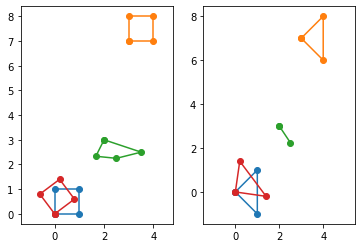

In [6]:
def draw_polygon(p, ax, closed=True, filled=False):
    if closed:
        pp = np.column_stack((p,p[:,0]))
    ax.plot(pp[0], pp[1], '-o')
    
    
plt.figure()
unit_square = np.array([[0, 1, 1, 0],
                        [0, 0, 1, 1]])
triangle = np.array([[0,  1, 1], 
                     [0, -1, 1]])


fig, axs = plt.subplots(1,2)
draw_polygon(unit_square, axs[0])
draw_polygon(triangle, axs[1])

T1 = np.array([[1, 0, 3],
               [0, 1, 7],
               [0, 0, 1]])
T2 = np.array([[5, 3, 2],
               [2, 4, 3],
               [1, 2, 1]])
T3 = np.array([[4, -3, 0],
               [3, 4, 0],
               [0, 0, 5]])

transforms = [T1, T2, T3]

for T in transforms:
    Tsquare = h2e( T @ e2h(unit_square))
    draw_polygon(Tsquare, axs[0])
    axs[0].axis('equal');
    
    Ttriangle = h2e( T @ e2h(triangle))
    draw_polygon(Ttriangle, axs[1])
    axs[1].axis('equal');



## Image Rotations

In this section you are going to use a homogeneous transform to rotate an image. We want to rotate the image around its center. The output image should have the same size as the input image.

In case the shape of an image (array) is ``(H,W)`` (where H stands for height and W stands for width), the center is given by: $(x_c,y_c)=(W/2, H/2)$.
Convince yourself that a rotation around the center is given by $T_\v t \tilde R_\phi T_{-\v t}$

Read the lecture notes on geometrical transformations to prepare for implementation of the image rotation. 

Below is the algorithm for the (WRONG) forward pass algorithm. Instead of the domain iterator described in the lecture notes a simple double loop over all pixels in the input image is used. As an extra a section is added to this lab that uses the domain iterator from the lecture notes.

In [7]:
def rotate_forward(F, phi):
    # First calculate the transform
    H, W = F.shape[:2]
    halfH, halfW = H/2, W/2
    T = np.array([[1, 0, halfW], [0, 1, halfH], [0, 0, 1]])
    cp = np.cos(phi)
    sp = np.sin(phi)
    R = np.array([[cp, -sp, 0], [sp, cp, 0], [0, 0, 1]])
    A = T @ R @ np.linalg.inv(T)
        
    # Now apply the transformation, and store the result in G.    
    G = np.zeros_like(F)
    for x in range(W):
        for y in range(H):
            xa, ya = h2e(A @ np.array([x, y, 1]))
            if 0<=ya<=H-1 and 0<=xa<=W-1:
                xai = np.rint(xa).astype(int)
                yai = np.rint(ya).astype(int)
                G[yai, xai] = F[y, x]
    return G

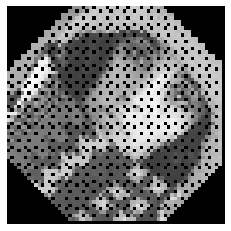

In [8]:
Gsmall_forward = rotate_forward(Fsmall, np.pi/4)
plt.imshow(Gsmall_forward)
plt.axis('off');

Yes, we are rotating the image, but no, it is not the correct result. You had better implement the backward algorithm. Implementing the backward algorithm requires your your ``pixel_value`` function and thus its parameters. (4pt)

In [9]:
def rotate_backward(F, phi, interpolation_method='nearest', 
                    border_method='constant', cval=0):
    """ Rotates the image F over an angle of phi, using the
    pixel_value function for interpolation."""
    
    H, W = F.shape[:2]
    halfH, halfW = H/2, W/2
    T = np.array([[1, 0, halfW], [0, 1, halfH], [0, 0, 1]])
    cp = np.cos(phi)
    sp = np.sin(phi)
    R = np.array([[cp, -sp, 0], [sp, cp, 0], [0, 0, 1]])
    A = T @ R @ np.linalg.inv(T)
    
    a = np.linalg.inv(T) @ np.array([0, 0, 1])
    b = R @ a
    c = T @ b

    g = np.zeros_like(F)
    for x in range(W):
        for y in range(H):
            xa, ya = h2e(np.linalg.inv(A) @ np.array([x, y, 1]))
            g[y][x] = pixel_value(F, ya, xa, interpolation_method, 
                border_method, cval)
    return g

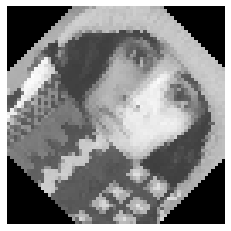

In [10]:
Gsmall_backward = rotate_backward(Fsmall, np.pi/4, 
                                  interpolation_method='nearest',
                                  border_method='constant')
plt.imshow(Gsmall_backward)
plt.axis('off');

If you feel lucky, or better yet have a reasonable fast computer you may try it on the full size image (and even this one is small for today's many megabytes images).

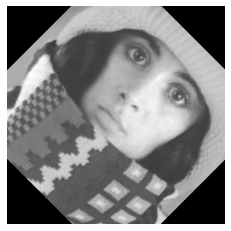

In [11]:
G_backward = rotate_backward(F, np.pi/4, 
                             interpolation_method='nearest',
                             border_method='constant')
plt.imshow(G_backward)
plt.axis('off');

OK let's try our luck even more. Would it work for a color image?

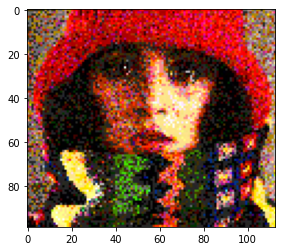

In [12]:
try:
    Fc = plt.imread('colortrui.png')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/colortrui.png")
    Fc = plt.imread('colortrui.png')
Fcsmall = Fc[::4,::4]
plt.imshow(Fcsmall);

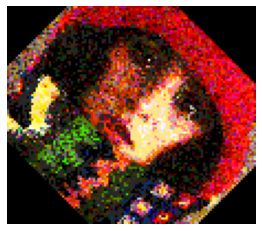

In [13]:
Gcsmall_backward = rotate_backward(Fcsmall, np.pi/4, 
                             interpolation_method='nearest',
                             border_method='constant')
plt.imshow(Gcsmall_backward)
plt.axis('off');

Note that you can use color images in the ``rotate_forward`` function as well. There is nothing special hidden in the ``rotate_backward`` function to deal with color images. Well, in the backward (and forward) code there *is* one line that is special for color images, the rest of the magic is all hidden in Numpy indexing and ufuncs.

Now that you have written you own rotation algorithm and hopefully have a basic understanding what is happening we switch to a warp (geometrical transform) algorithm from the skimage package.
Most computer vision libraries, like skimage and OpenCV, have warp algorithms available where you just have to give the homogeneous transformation matrix and the size of the output image as arguments.

The following command gives you an explanation of the `warp` function.

In [14]:
# Uncomment the following line to get information on the `warp` function. However, recomment before you submit:
# this "notebook magic" breaks the autotests....

#warp?

Calculate the transformation matrix needed to turn this picture over an angle of $\pi/4$, then use the `warp` function to apply it to the image $F$. (3pt)

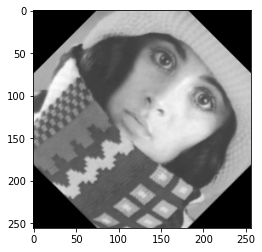

In [15]:
# First calculate the transformation matrix transform_matrix
# that the warp function needs (Read the documentation:
# have you already discovered the ``warp?`` command to 
# show the docstring of the warp function?)

def get_pi_over_4_rotation_matrix(H, W):
    """
    Returns the projective transformation matrix that rotates an image of size H x W 
    about its center (H/2, W/2) over an angle of pi/4.
    """
    halfH, halfW = H/2, W/2
    T = np.array([[1, 0, halfW], [0, 1, halfH], [0, 0, 1]])
    cp = np.cos(-np.pi / 4)
    sp = np.sin(-np.pi / 4)
    R = np.array([[cp, -sp, 0], [sp, cp, 0], [0, 0, 1]])
    A = T @ R @ np.linalg.inv(T)
    return A


transform_matrix = get_pi_over_4_rotation_matrix(F.shape[0], F.shape[1])
Gwarp = warp(F, transform_matrix)
plt.imshow(Gwarp);

Comparing the Gwarp image with the Gbackward image with my own implementation of the ``pixel_value`` function the images were almost equal except at the boundaries of the original image. If you can come up with a better implementation matching the ``skimage.transform.warp`` function you get extra credit! But maybe there is some error in the warp algorithm... If you find that error you will become famous (well at least known to the skimage developers).

## Estimating an Affine Transform

The generic affine transform can be written as the matrix transform:
\begin{align}
    \hv x' = A\,\hv x
\end{align}
where
\begin{align}
A = \begin{bmatrix}
a & b & c\\
d & e & f\\
0 & 0 & 1
\end{bmatrix}
\end{align}
To specify an affine transform we need to specify what the transform $\hv x_i'$ is of three points $\hv x_i$ for $i=1,2,3$. Read the lecture notes (chapter on homogeneous coordinates in the Math Tools part) and watch the video of the lecture.

An affine transform maps a parallelogram onto a (different) parallelogram. Note that a parallelogram is defined by three of its vertices. The fourth one follows from the given three.

Given these three point correspondences we may write (in block matrix notation):
\begin{align}
    \begin{bmatrix}
    \hv x'_1 & \hv x'_2 & \hv x'_3 
    \end{bmatrix} &=
    A \begin{bmatrix}
    \hv x_1 & \hv x_2 & \hv x_3 
    \end{bmatrix}\\
    X' &= A X
\end{align}
All three matrices are $3\times3$ matrices and in case $X$ is non-singular we may write:
\begin{align}
    A = X'\,X\inv
\end{align}

In practice the above method to calculate the matrix A is not often used in computer vision. 

We can however rewrite the $\hv x_i' = A \hv x_i$ in the following way (see the lecture notes):
\begin{split}\begin{pmatrix}x_i'\\ y_i'\end{pmatrix} =
\begin{pmatrix}x_i& y_i& 1& 0& 0& 0\\0& 0& 0& x_i& y_i& 1 \end{pmatrix}
\begin{pmatrix}a\\b\\c\\d\\e\\f \end{pmatrix}\end{split}
Here we have rewritten the original equation in such a way that all the parameters to be estimated are collected in a parameter vector.

The above is just for one point correspondence. For 3 point
correspondences we can stack the $x_i', y_i'$ values and also add two rows to the matrix on the right hand side. For three points we have:

\begin{align}
   \begin{pmatrix}x_1'\\ y_1'\\x_2'\\ y_2'\\x_3'\\ y_3'\end{pmatrix} = 
   \begin{pmatrix}
   x_1& y_1& 1& 0& 0& 0\\0& 0& 0& x_1& y_1& 1\\
   x_2& y_2& 1& 0& 0& 0\\0& 0& 0& x_2& y_2& 1\\
   x_3& y_3& 1& 0& 0& 0\\0& 0& 0& x_3& y_3& 1 \end{pmatrix}
   \begin{pmatrix}a\\b\\c\\d\\e\\f \end{pmatrix}
\end{align}
or:
\begin{align}
   \v q = M \v p
\end{align}
The $6\times6$ matrix $M$ is invertible (given three non collinear
points) and thus:
\begin{align}
   \v p = M\inv \v q
\end{align}
To get the matrix $A$ from $p$ we have to fill in a 3x3 matrix with the correct values from $p$.

In the remainder of this section you are asked to write the code to select a parallelogram in an image (say F) by specifying three of the points and warp that parallelogram to a new image.

First we specify and draw a parallelogram on top of an image.

In [16]:
pts1 = [np.array([60, 60]),
        np.array([100, 30]),
        np.array([100, 90])]

pts2 = [np.array([0, 255]),
        np.array([0, 0]),
        np.array([255, 255])]

pts3 = [np.array([60, 40]),
        np.array([120, 40]),
        np.array([60, 100])]

def parallelogram(x1, x2, x3):
    return np.column_stack((x1, x2, x2 + (x3-x1), x3))

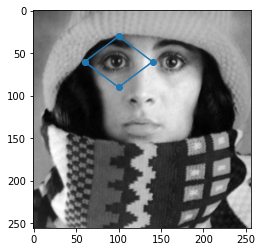

In [17]:
x1, x2, x3 = pts1
F = plt.imread('trui.png')
plt.imshow(F)
draw_polygon(parallelogram(x1, x2, x3), plt.gca())

Next you have to construct the matrix $M$ and the vector $q$ and from that calculate the affine transformation matrix. The vectors $\v x_i$ are encoded in Python as the (2,) arrays ``x1``, ``x2`` and ``x3``. The vectors $\v x_i'$ are encoded as the arrays ``xa1``, ``xa2`` and ``xa3``. (5pt)

In [18]:
def affine_transform_matrix(x1, x2, x3, xa1, xa2, xa3):
    """
    Calculates the affine transformation matrix A that maps 
    (in homogeneous coordinates) the vectors xi to xai. The
    vectors are given in Euclidean coordinates.
    """
    M = np.array([[x1[0], x1[1], 1, 0, 0, 0],[0, 0, 0, x1[0], x1[1], 1],
                  [x2[0], x2[1], 1, 0, 0, 0],[0, 0, 0, x2[0], x2[1], 1],
                  [x3[0], x3[1], 1, 0, 0, 0],[0, 0, 0, x3[0], x3[1], 1]])
    inv = np.linalg.inv(M)
    q = np.array([xa1[0], xa1[1], xa2[0], xa2[1], xa3[0], xa3[1]])
    p = inv @ q
    A = np.array([[p[0],p[1],p[2]], [p[3],p[4],p[5]], [0, 0, 1]])
    return A

Next you have to write the function ``affine_transform_image`` that is given three points x1, x2 and x3 in the input image F and maps these to the corners of the resulting image xa1=[0,0], xa2=[W-1,0] and xa3=[0,H-1], where (H,W) is the shape of the new image array. Note that F can be a color image or a scalar image. Use the ``warp`` function from skimage. Note that this function has a named argument ``output_shape`` to set the shape of the output image. (3pt)

In [19]:
def affine_transform_image(F, x1, x2, x3, H, W):
    transform_matrix = affine_transform_matrix(x1, x2, x3, [0, 0], [W - 1, 0], [0, H - 1])
    Gwarp = warp(F, np.linalg.inv(transform_matrix), output_shape=(H,W))
    return Gwarp

Use the following cells to (visually) test your `affine_transform_image` function.

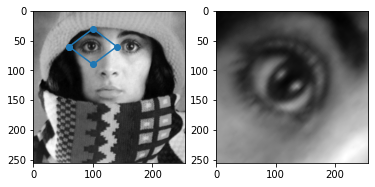

In [20]:
x1, x2, x3 = pts1
plt.subplot(121)
plt.imshow(F)
draw_polygon(parallelogram(x1, x2, x3), plt.gca())
G = affine_transform_image(F, x1, x2, x3, *F.shape)
plt.subplot(122)
plt.imshow(G);

In [21]:
pts = [(10, 10), (20, 30), (100, 200)]
vals = [G[pt] for pt in pts]
vals

[0.2761246, 0.30294687, 0.52034736]

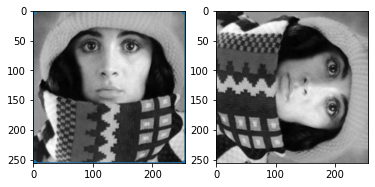

In [22]:
x1, x2, x3 = pts2
plt.subplot(121)
plt.imshow(F)
draw_polygon(parallelogram(x1, x2, x3), plt.gca())
G = affine_transform_image(F, x1, x2, x3, *F.shape)
plt.subplot(122)
plt.imshow(G);

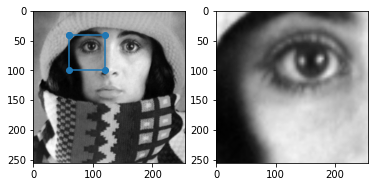

In [23]:
x1, x2, x3 = pts3
plt.subplot(121)
plt.imshow(F)
draw_polygon(parallelogram(x1, x2, x3), plt.gca())
G = affine_transform_image(F, x1, x2, x3, *F.shape)
plt.subplot(122)
plt.imshow(G);

## Estimating a Projective Transform

In general we are not so lucky that the transformation, which a camera performs on a flat piece of paper, is affine. That only happens if the two are relatively far away from each other (in terms of the camera’s focal length). A more realistic transformation is the *projective transformation.*

The goal in this section is to take the following image, and to warp the quadrilateral flyer into a separate, rectangular picture (the image that follows).

<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/flyeronground.png">
<img src="https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/flyerwarped.png">

Please read the section on 'Homogeneous Coordinates' in the 'Mathematical Tools' part of the lecture notes. Especcially the subsections 'Projective Transform' and 'Estimating Parameters/Projective Transform'.

This is exactly the transformation that a pinhole camera applies to a planar object when (ahem) projecting it to the image plane. In Week 6 (and Chapter 2 in the Computer Vision part of the Lecure notes) you can find out how this transformation is connected to the imaging process in a camera, and we’ll even to a lab exercise about that. For now, all you need to know is that a projective transformation is capable of transforming an arbitrary quadrilateral in the plane into another arbitrary quadrilateral (this could be called its ‘defining property’).

The perspective transform is the generic transform characterized with
a 3x3 homogeneous matrix:
\begin{align}
   s\begin{pmatrix}x'\\y'\\1\end{pmatrix} =& 
   \begin{pmatrix}a & b & c\\d & e & f\\g & h & i\end{pmatrix}
   \begin{pmatrix}x\\y\\1\end{pmatrix} \\
   \hv x' \sim& P\,\hv x
\end{align}
Note the scaling factor $s$ in the above expression which is due to
the normalization that is inherent when using homogeneous coordinates
(and a transform for which elements $g$ and $h$ are not zero). This is
also why in the second equation we write $\sim$ instead of $=$.

In the lecture notes it is explained that this can be rewritten as:
\begin{align}
   \begin{pmatrix}
   x & y & 1 & 0 & 0 & 0 & -x'x & -x'y & -x'\\
   0 & 0 & 0 & x & y & 1 & -y'x & -y'y & -y'
   \end{pmatrix}
   \begin{pmatrix}a\\b\\c\\d\\e\\f\\g\\h\\i \end{pmatrix} =
   \begin{pmatrix}0\\0 \end{pmatrix} 
\end{align}
Stacking 4 point correspondences we arrive at:
\begin{align}
   \begin{pmatrix}
   x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1'x_1 & -x_1'y_1 & -x_1'\\
   0 & 0 & 0 & x_1 & y_1 & 1 & -y_1'x_1 & -y_1'y_1 & -y_1'\\
   x_2 & y_2 & 1 & 0 & 0 & 0 & -x_2'x_2 & -x_2'y_2 & -x_2'\\
   0 & 0 & 0 & x_2 & y_2 & 1 & -y_2'x_2 & -y_2'y_2 & -y_2'\\
   x_3 & y_3 & 1 & 0 & 0 & 0 & -x_3'x_3 & -x_3'y_3 & -x_3'\\
   0 & 0 & 0 & x_3 & y_3 & 1 & -y_3'x_3 & -y_3'y_3 & -y_3'\\
   x_4 & y_4 & 1 & 0 & 0 & 0 & -x_4'x_4 & -x_4'y_4 & -x_4'\\
   0 & 0 & 0 & x_4 & y_4 & 1 & -y_4'x_4 & -y_4'y_4 & -y_4'
   \end{pmatrix}
   \begin{pmatrix}a\\b\\c\\d\\e\\f\\g\\h\\i \end{pmatrix} =&
   \begin{pmatrix}0\\0\\0\\0\\0\\0\\0\\0 \end{pmatrix} \\
   \v M \v p =& \v 0
\end{align}
This is a homogeneous system of equations. It can be shown that in
case the points are not colinear there is one non trivial solution for
the vector $\v p$.


In this Lab Exercise we work with only 4 point correspondences to define the projective transformation. In theory these are all that's needed. In practice the points are not exact, there is some noise due to the measurement process. In a later lab exercise you have to stitch images together and then we need many more point correspondences to do the estimation of the projective transform.

In the lecture notes it is explained in what way the SVD can be used to solve an equation of the form $M\v p = \v 0$ where $M$ is $2n\times9$ (in the above equation we have taken the minimal $n=4$). In this lab you may assume $n=4$ but it is wise anyway to use the 'SVD trick' to find the null vector of $M$.

First you need to write the function ``projective_transform_matrix`` that has parameters ``x1``, ``x2``, ``x3``, ``x4`` and ``xa1``, ``xa2``, ``xa3``, ``xa4`` being the 4 source points and the 4 transformed points. Each of these points is a (2,) array.

We provide you with the code to draw a quadrilateral on top of an image.

In [24]:
try:
    F = plt.imread('flyeronground.png')
except FileNotFoundError:
    wget.download("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_images/flyeronground.png")
    F = plt.imread('flyeronground.png')

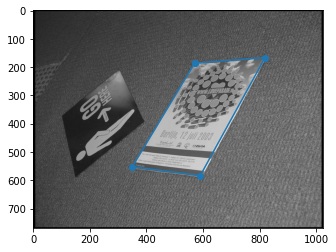

In [25]:
x1 = np.array([570, 186])
x2 = np.array([819, 166])
x3 = np.array([590, 583])
x4 = np.array([350, 552])

def quadrilateral(x1, x2, x3, x4):
    return np.column_stack((x1, x2, x3, x4))

plt.imshow(F)
draw_polygon(quadrilateral(x1, x2, x3, x4), ax=plt.gca())

Next you have to write the function ``projective_transform_matrix`` that uses the 'SVD trick' to calculate the projective transform matrix $P$ given 4 point correspondences. (5pt)

In [26]:
def projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4):
    """
    Computes the projective transformation (in homogeneous coordinates) that
    transforms vectors xi into xai. (The vectors are given in Euclidean
    coordinates).
    """
    M = np.array([[x1[0], x1[1], 1, 0, 0, 0, -xa1[0]*x1[0], -xa1[0]*x1[1], -xa1[0]],
                  [0, 0, 0, x1[0], x1[1], 1, -xa1[1]*x1[0], -xa1[1]*x1[1], -xa1[1]],
                  [x2[0], x2[1], 1, 0, 0, 0, -xa2[0]*x2[0], -xa2[0]*x2[1], -xa2[0]],
                  [0, 0, 0, x2[0], x2[1], 1, -xa2[1]*x2[0], -xa2[1]*x2[1], -xa2[1]],
                  [x3[0], x3[1], 1, 0, 0, 0, -xa3[0]*x3[0], -xa3[0]*x3[1], -xa3[0]],
                  [0, 0, 0, x3[0], x3[1], 1, -xa3[1]*x3[0], -xa3[1]*x3[1], -xa3[1]],
                  [x4[0], x4[1], 1, 0, 0, 0, -xa4[0]*x4[0], -xa4[0]*x4[1], -xa4[0]],
                  [0, 0, 0, x4[0], x4[1], 1, -xa4[1]*x4[0], -xa4[1]*x4[1], -xa4[1]],
                 ])
    u, s, vh = np.linalg.svd(M, full_matrices=True)
    q = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1])
    p = np.transpose(vh) @ q
    A = np.array([[p[0], p[1], p[2]], 
                  [p[3], p[4], p[5]], 
                  [p[6], p[7], p[8]]])
    return A

Given 4 points x1, x2, x3 and x4 in the original image F (all given as (2,) shaped arrays) we want to warp the image such that x1 projects to (0,0) in the resulting image, x2 projects to (W-1,0), x3 to (W-1,H-1) and x4 to (0,H-1) where (H,W) is the shape of the resulting image. Probably the flyer lying on the ground is an A4 sheet of paper so something like (H,W) = (800,600) will do.
In the function below you have to use the ``skimage.transform.warp`` function. Note that you can use the ``output_shape`` named argument to set the shape of the resulting image. (3pt)

In [27]:
def projective_transform_image(F, x1, x2, x3, x4, H, W):
    transform_matrix = projective_transform_matrix(x1, x2, x3, x4, [0, 0], [W - 1, 0], [W - 1, H - 1], [0, H - 1])
    Gwarp = warp(F, np.linalg.inv(transform_matrix), output_shape=(H,W))
    return Gwarp

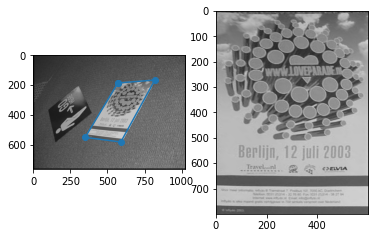

In [28]:
x1 = np.array([570, 186])
x2 = np.array([819, 166])
x3 = np.array([590, 583])
x4 = np.array([350, 552])

plt.subplot(121)
plt.imshow(F)
draw_polygon(quadrilateral(x1, x2, x3, x4), ax=plt.gca())
plt.subplot(122)
G = projective_transform_image(F, x1, x2, x3, x4, 800, 600)
plt.imshow(G);

In [29]:
pts = [(10, 10), (20, 30), (100, 200)]
np.array([G[pt] for pt in pts])

array([[0.626669  , 0.626669  , 0.626669  , 1.        ],
       [0.62369746, 0.62369746, 0.62369746, 1.        ],
       [0.18059579, 0.18059579, 0.18059579, 1.        ]], dtype=float32)

## Appendix: Using a Domain Iterator

NOTE: this section is not obligatory, it is only included to make the code connection with the lecture notes for those interested in the programming aspects.

In the lecture notes the source code for the domain iterator is given. The code below is slightly changed to deal with other imports. Although the code for the forward transform now is now looking very much like a pseudo code algorithm, it requires some more abstractions (the domain iterator and the pixel class)

In [30]:
import itertools

class pixel(tuple):
    pass

class pixel(tuple):
    """a pixel is just a tuple with some extra methods"""
    def __lt__(self, p):
        return all( [a < b for a,b in zip(self, p)] )
    
    def __le__(self, p):
        return all( [a <= b for a,b in zip(self, p)] )
    
    def isin(self, end, start=pixel((0,0))):
        return all( [a<x and x<b for a,b,x in zip(start,end,self)] )

    def rint(self):
        return pixel([np.rint(a).astype(int) for a in self])
    
    
def domainIterator(end, start=None, step=None):
    """
    Returns an iterator that yields all multi-indices in the range
    (start)-(end) with stepsizes (step) in rasterscan order
    """
    if type(end) != np.ndarray:
        end = np.array(end);
    if start == None:
        start = 0*end;
    elif type(start) != np.ndarray:
        start = np.array(start)
    if len(start) != len(end):
        raise ValueError("start and end should have same length")
    if step != None and type(step) != np.ndarray:
        step = np.array(step)

    if step is None:
        return itertools.product(*[ np.arange(*p) for p in zip(start, end) ])
    else:
        return itertools.product(*[ np.arange(*p) for p in zip(start, end, step) ])

The code for the forward transform is also given in the lecture notes:

In [31]:
def geoOp_fwd(f, phi):
    fdomain = f.shape[:2]
    g = np.zeros_like(f)
    for p in domainIterator(fdomain):
        q = phi(p).rint()
        if q.isin(fdomain):
            g[q] = f[p]
    return g

In [32]:
def rotator(angle):
    """a rotator around the origin"""
    ca = np.cos(angle)
    sa = np.sin(angle)
    R = np.array([[ca, -sa], [sa, ca]])
    def rotate(t):
        return pixel(R @ np.array(t))
    return rotate

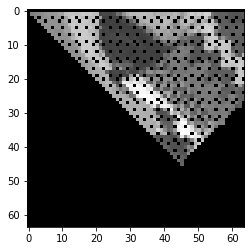

In [33]:
Gsmall_DI = geoOp_fwd(Fsmall, rotator(np.pi/4))
plt.imshow(Gsmall_DI);